### Overview of the notebook

* [Motivation](#chapter1)

* [Basic statistics](#chapter2)

* [Basic statistics](#chapter3)

* [Discussion](#chapter4)

* [Contributions](#chapter5)

### Motivation <a class="anchor" id="chapter1"></a>

### Basic statistics <a class="anchor" id="chapter2"></a>

In [2]:
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import urllib.request
import json
import re
import os
import collections

from fa2 import ForceAtlas2
from matplotlib.lines import Line2D

In [3]:
characters_df = pd.read_csv('name_of_villains_4ang.csv', sep = ';')

In [4]:
# characters_df[~characters_df.name_of_villains.str.contains(":")]
# This line has to run if we aree in Windows environment

In [5]:

# Get description for all villains
def get_description(name):
    baseurl = "https://disney.fandom.com/api.php?"
    action = "action=query"
    title = "titles=" + name
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikijson = json.loads(wikitext)
    
    #page id check
    page_ids = list(wikijson['query']['pages'].keys())
    #get description
    description = wikijson['query']['pages'][page_ids[0]]['revisions'][0]['slots']['main']['*']
    return description


In [5]:
# Get the path for the folder that we keep the descriptions in 
'''
script_path = os.getcwd()
folder = 'Villains3/'
path = os.path.join(script_path,folder)
'''

In [ ]:
# Load the description for all the villains into a txt file
'''
exceptions = []
for name in tqdm(list(characters_df['name_of_villains'].values)):
    try:
        villains_description = get_description(name.replace(' ','_'))
        with open(path + name + '.txt', 'w') as file:
            json.dump(villains_description, file)
            
            
            
    except:
        print(name)
        exceptions.append(name)
'''

In [6]:
universe_pattern = ['\[\[Category:(Marvel) Cinematic Universe characters\]\]',
                        '\[\[Category:(Marvel) Comics\]\]',
                        '\[\[Category:(Marvel) Comics characters\]\]',
                        '\[\[Category:(Pixar) characters\]\]',
                        '\[\[Category:(Disney) characters\]\]',
                        '\[\[Category:(Star Wars) characters\]\]',
                        '\[\[Category:(Star Wars) villains\]\]']

In [7]:
def get_category(characters_df, pat):
    script_path = os.getcwd()
    folder = 'Villains2/'
    path = os.path.join(script_path,folder)
    
    pattern = pat

    
    categories = []
    for char in characters_df.name_of_villains.values:
        # open the description files
        with open(path + char + '.txt', 'r') as f:
            node_description = f.read()
        
        find_categories = []
        for p in pattern:
            find_categories += re.findall(p, node_description)
            
        for cat in find_categories:
            categories.append((char, cat))
            

    return categories

In [8]:
universes = get_category(characters_df, universe_pattern)

In [9]:
df = pd.DataFrame(set(universes))

In [10]:
df['name_of_villains'] = df[0]
del df[0]
df['Universe'] = df[1]
del df[1]

In [11]:
df_villains = pd.merge(characters_df, df, on='name_of_villains', how='left')
df_villains = df_villains.fillna('N/A') # N/A means not applicable, suits better for this case

In [12]:
len(df_villains)

2772

In [13]:
df_villains.groupby('Universe').count()

,name_of_villains
Universe,
Disney,1982
Marvel,282
N/A,329
Pixar,93
Star Wars,86


In [14]:
#check if there are characters in multiple universes
doubles = df_villains[df_villains.duplicated(subset=['name_of_villains'], keep=False)]
doubles

,name_of_villains,Universe
471,Cobweb,Disney
472,Cobweb,Pixar
640,Dracula,Marvel
641,Dracula,Disney
722,Ercole Visconti,Pixar
723,Ercole Visconti,Disney
853,Frankenstein's Monster,Marvel
854,Frankenstein's Monster,Disney
1031,Grubs,Disney
1032,Grubs,Pixar


#### we have few villains that belong to multiple uniiverses, we need to delete their doubles

In [15]:
# we sort them in a way that din´sney comes first and then delete the duplicates of the first column
# this way the charcters will not belong to disney anymore
df_villains = df_villains.sort_values('Universe')
df_villains = df_villains.drop_duplicates(subset='name_of_villains', keep="last")

len(df_villains)

2766

Now, they are as many as they should be

in name columns we have also organizations. we need to remove them

In [16]:
org_pattern = ['\[\[Category:(Organizations)\]\]']

In [17]:
organization = get_category(df_villains, org_pattern)

In [18]:
df = pd.DataFrame(set(organization))

In [19]:
df['name_of_villains'] = df[0]
del df[0]
df['Org'] = df[1]
del df[1]

In [20]:
df

,name_of_villains,Org
0,W.E.E.,Organizations
1,S.T.U.A.R.T.,Organizations
2,Confederacy of Independent Systems,Organizations
3,Coven of the Eight,Organizations
4,Sith,Organizations
5,Time Variance Authority,Organizations
6,Organization XIII,Organizations
7,A.I.M.,Organizations
8,Lemons,Organizations
9,L.O.V.E.M.U.F.F.I.N.,Organizations


In [21]:
df_villains = pd.merge(df_villains, df, on='name_of_villains', how='left')


In [22]:
df_villains

,name_of_villains,Universe,Org
0,Komodo Dragon,Disney,NaN
1,Roger Klotz,Disney,NaN
2,Aldrin Klordane,Disney,NaN
3,Captain Klegghorn,Disney,NaN
4,Sirocco,Disney,NaN
...,...,...,...
2761,Captain Phasma,Star Wars,NaN
2762,Emperor's Royal Guards,Star Wars,NaN
2763,Pyre,Star Wars,NaN
2764,Taron Malicos,Star Wars,NaN


In [23]:
df_villains.loc[df_villains['Org'] == 'Organizations']

,name_of_villains,Universe,Org
58,Knights of Rodegan,Disney,Organizations
213,L.O.V.E.M.U.F.F.I.N.,Disney,Organizations
625,Organization XIII,Disney,Organizations
626,Organization (PKNA),Disney,Organizations
813,Separatists of Saporia,Disney,Organizations
877,Makucha's Army,Disney,Organizations
1270,Army of Scar,Disney,Organizations
1602,F.O.W.L.,Disney,Organizations
1980,Time Variance Authority,Marvel,Organizations
1984,Thunderbolts,Marvel,Organizations


In [24]:
df_villains = df_villains[df_villains.Org != 'Organizations']

In [25]:
df_villains

,name_of_villains,Universe,Org
0,Komodo Dragon,Disney,NaN
1,Roger Klotz,Disney,NaN
2,Aldrin Klordane,Disney,NaN
3,Captain Klegghorn,Disney,NaN
4,Sirocco,Disney,NaN
...,...,...,...
2761,Captain Phasma,Star Wars,NaN
2762,Emperor's Royal Guards,Star Wars,NaN
2763,Pyre,Star Wars,NaN
2764,Taron Malicos,Star Wars,NaN


In [26]:
# drop organization column
df_villains = df_villains.drop('Org', 1)

<ipython-input-26-7ffd90cacfdc>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_villains = df_villains.drop('Org', 1)


In [27]:
df_villains

,name_of_villains,Universe
0,Komodo Dragon,Disney
1,Roger Klotz,Disney
2,Aldrin Klordane,Disney
3,Captain Klegghorn,Disney
4,Sirocco,Disney
...,...,...
2761,Captain Phasma,Star Wars
2762,Emperor's Royal Guards,Star Wars
2763,Pyre,Star Wars
2764,Taron Malicos,Star Wars


In [28]:
df_villains.groupby('Universe').count()

,name_of_villains
Universe,
Disney,1968
Marvel,274
N/A,324
Pixar,92
Star Wars,80


In [29]:
# Get the hyperlinks
def get_hyperlinks(df_villains):
    script_path = os.getcwd()
    folder = 'Villains2/'
    path = os.path.join(script_path,folder)
    
    pattern = '\[\[(.*?)(?:\|.*?)?\]\]'
    links = []
    for char in df_villains.name_of_villains.values:
        # open the zelda description files
        with open(path + char + '.txt', 'r') as f:
            node_description = f.read()
    
        links_square = re.findall(pattern, node_description)
   
        # For pattern including square brackets  
        for name in links_square:
            # check if character is in the char list
            if name in df_villains.name_of_villains.values:
                links.append((char, name))
            else:
                continue
    return links

In [30]:
links = get_hyperlinks(df_villains)

In [31]:
len(links)

9874

In [32]:
links

[('Komodo Dragon', 'Ora'),
 ('Komodo Dragon', 'Chuluun'),
 ('Komodo Dragon', 'Smun'),
 ('Komodo Dragon', 'Jiona'),
 ('Komodo Dragon', 'Fahari'),
 ('Komodo Dragon', 'Ora'),
 ('Komodo Dragon', 'Ora'),
 ('Komodo Dragon', 'Makucha'),
 ('Komodo Dragon', 'Chuluun'),
 ('Komodo Dragon', 'Mama Binturong (character)'),
 ('Roger Klotz', 'Boomer Bledsoe'),
 ('Roger Klotz', 'Willy White'),
 ('Roger Klotz', 'Lamar Bone'),
 ('Roger Klotz', 'Guy Graham'),
 ('Roger Klotz', 'Percy Femur'),
 ('Roger Klotz', 'Boomer Bledsoe'),
 ('Roger Klotz', 'Willy White'),
 ('Aldrin Klordane', 'The Coachman'),
 ('Aldrin Klordane', 'Fat Cat'),
 ('Aldrin Klordane', 'Professor Norton Nimnul'),
 ('Aldrin Klordane', 'Percy (Rescue Rangers)'),
 ('Aldrin Klordane', 'Percy (Rescue Rangers)'),
 ('Aldrin Klordane', 'Fat Cat'),
 ('Aldrin Klordane', "Fat Cat's Gang"),
 ('Aldrin Klordane', 'Professor Norton Nimnul'),
 ('Aldrin Klordane', 'Fat Cat'),
 ('Aldrin Klordane', 'Percy (Rescue Rangers)'),
 ('Captain Klegghorn', 'Lord Dragau

In [33]:
# Make a network
villians_network = nx.DiGraph()

# Add egdes
villians_network.add_edges_from(links)

# Discard isolated nodes
villians_network.remove_nodes_from(list(nx.isolates(villians_network)))

In [34]:
# Extract the giant connected component
gcc = villians_network.subgraph(max(nx.weakly_connected_components(villians_network), key=len))

In [35]:
nodes = len(gcc.nodes)

In [36]:
nodes

1545

In [37]:
edges = len(gcc.edges)

In [38]:
edges

5533

In [39]:
top_indegree = sorted(dict(gcc.in_degree()).items(), key=lambda item: item[1], reverse=True)
top_indegree[:5]

[('Captain Hook', 79),
 ('Pete', 73),
 ('Maleficent', 69),
 ('Hades', 62),
 ('Jafar', 59)]

In [40]:
top_outdegree = sorted(dict(gcc.out_degree()).items(), key=lambda item: item[1], reverse=True)
top_outdegree[:5]

[('Captain Hook', 33),
 ('Cruella De Vil', 31),
 ('The Evil Queen', 30),
 ('Maleficent', 30),
 ('Hades', 29)]

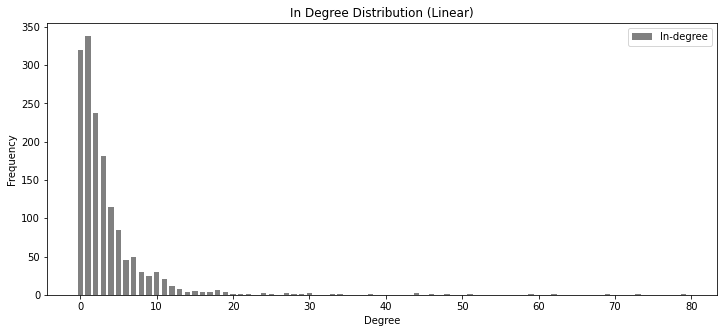

In [41]:
# Plotting the in-degree distribution
degree = sorted([d for n, d in gcc.in_degree()])
degree_count = collections.Counter(degree)
deg, count = zip(*degree_count.items())

# With linear axes
plt.figure(figsize=(12,5))
plt.bar(deg, count, width=0.7, color="grey")
plt.title("In Degree Distribution (Linear)")
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.legend(['In-degree'])

plt.show()

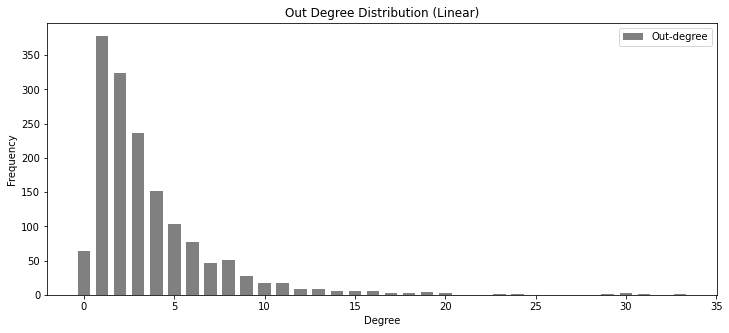

In [42]:
# Plotting the out-degree distribution
degree = sorted([d for n, d in gcc.out_degree()])
degree_count = collections.Counter(degree)
deg, count = zip(*degree_count.items())

# With linear axes
plt.figure(figsize=(12,5))
plt.bar(deg, count, width=0.7, color="grey")
plt.title("Out Degree Distribution (Linear)")
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.legend(['Out-degree'])

plt.show()

In [43]:
# Get node positions based on the Force Atlas 2 algorithm
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          edgeWeightInfluence=0.5,
                          # Performance
                          jitterTolerance=0.2, # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.6,
                          # Tuning
                          scalingRatio=5.0,
                          strongGravityMode=True,
                          gravity=1,
                          # Log
                          verbose=False)

In [44]:
gcc_undirected = gcc.to_undirected()

In [45]:
degrees = [val for node,val in gcc_undirected.degree()]

# Scale node size according to degree
node_size = [i * 1.6 for i in degrees]

In [46]:
# Get color nodes according to the universe
marvel_df = df_villains.loc[(df_villains['Universe'] == 'Marvel')]
star_wars_df = df_villains.loc[(df_villains['Universe'] == 'Star Wars')]
pixar_df = df_villains.loc[(df_villains['Universe'] == 'Pixar')]
disney_df = df_villains.loc[(df_villains['Universe'] == 'Disney')]
unkown_df = df_villains.loc[(df_villains['Universe'] == 'N/A')]

color_roles = []
for node in gcc_undirected.nodes():
    if node in marvel_df.name_of_villains.values:
        color_roles.append('#00FF00')
    elif node in star_wars_df.name_of_villains.values:
        color_roles.append('#FF0000')
    elif node in pixar_df.name_of_villains.values:
        color_roles.append('#000000')
    elif node in disney_df.name_of_villains.values:
        color_roles.append('#04D8B2')
    elif node in unkown_df.name_of_villains.values:
        color_roles.append('#FF7F50')

In [47]:
edge_colors = []
for u, v in gcc_undirected.edges():
    edge_colors.append("#C0C0C0")

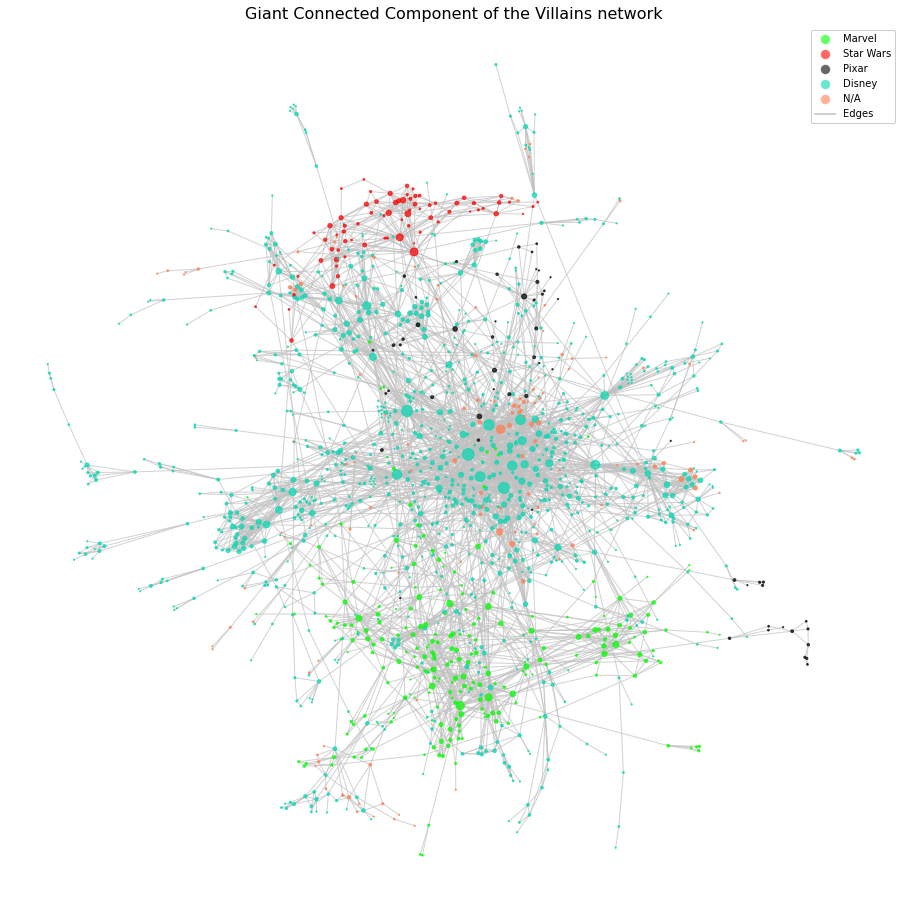

In [48]:
f = plt.figure(figsize=(16,16))
ax = plt.gca()

# Create a legend for the different colors
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Marvel',
                          markerfacecolor="#00FF00", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Star Wars',
                          markerfacecolor="#FF0000", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Pixar',
                          markerfacecolor="#000000", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Disney',
                          markerfacecolor="#04D8B2", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='N/A',
                          markerfacecolor="#FF7F50", markersize=10, alpha=0.6),
                   Line2D([0], [0], color="#C0C0C0", label='Edges')]

positions = forceatlas2.forceatlas2_networkx_layout(gcc_undirected, pos=None, iterations=50)
nodes = nx.draw_networkx_nodes(gcc_undirected, positions, node_size=node_size, node_color=color_roles, alpha=0.7)
edges = nx.draw_networkx_edges(gcc_undirected, positions, edge_color=edge_colors,alpha=0.7)

plt.axis('off')
plt.title("Giant Connected Component of the Villains network", fontsize=16)

plt.legend(handles=legend_elements, facecolor='white', framealpha=1)

plt.show()

In [55]:
df_villains

,name_of_villains,Universe
0,Komodo Dragon,Disney
1,Roger Klotz,Disney
2,Aldrin Klordane,Disney
3,Captain Klegghorn,Disney
4,Sirocco,Disney
...,...,...
2761,Captain Phasma,Star Wars
2762,Emperor's Royal Guards,Star Wars
2763,Pyre,Star Wars
2764,Taron Malicos,Star Wars


In [49]:
# add attributes to the nodes of gcc_undirected

# 1. create dictionary from df_villains dataframe
node_attr = df_villains.set_index('name_of_villains').to_dict('index')
nx.set_node_attributes(gcc_undirected, node_attr)


In [50]:
gcc_undirected.nodes['Toon'] # now each node has attribute of universe

{'Universe': 'Disney'}

## We will figure out which edges connect villains from different universes

In [51]:
# We don't take into account characters thet are not assigned in any of our four main universes
list_multiverse = []
for u, v in gcc_undirected.edges():
    role_u = gcc_undirected.nodes[u]['Universe']
    role_v = gcc_undirected.nodes[v]['Universe']
    if role_u == 'N/A':
        continue
    elif role_v == 'N/A':
        continue
    else:
        if role_u != role_v:
            list_multiverse.append((u,v))
        else:
            continue

In [52]:
len(list_multiverse)

95

These are all the edges connecting characters from different universes

In [53]:
list_multiverse

[('Felicia', 'Jabba the Hutt'),
 ('Captain Hook', 'Randall Boggs'),
 ('Captain Hook', 'Doctor Doom'),
 ('Captain Hook', 'President Loki'),
 ('Captain Hook', 'Ercole Visconti'),
 ('Scar', 'Hopper'),
 ('Scar', 'Darth Vader'),
 ('Hades', "Lots-o'-Huggin' Bear"),
 ('Hades', 'Big Baby'),
 ('Mandarin', 'Eric Savin'),
 ('Gaston', 'Ercole Visconti'),
 ('Duff Killigan', 'Darth Vader'),
 ('Skeletons', 'Grim Reaper'),
 ('The Grim Reaper', 'Grim Reaper'),
 ('The Grim Reaper', 'Hela'),
 ('Pete', 'Jango Fett'),
 ('The Evil Queen', 'Palpatine'),
 ('The Evil Queen', "Frankenstein's Monster"),
 ('Lord Dominator', 'Darth Vader'),
 ('Lyle Tiberius Rourke', "Lots-o'-Huggin' Bear"),
 ('Lyle Tiberius Rourke', 'Miles Axlerod'),
 ('Lyle Tiberius Rourke', 'Ernesto de la Cruz'),
 ('Davy Jones', 'Jabba the Hutt'),
 ('Maleficent', 'Miss Fritter'),
 ('Khaka Peu Peu', 'Green Goblin'),
 ('Green Goblin', 'Creeper'),
 ('Julius', "Frankenstein's Monster"),
 ('The Collector', 'Collector'),
 ('Cruella De Vil', 'Dracula')

we see the characters with the most connections to other universes

In [54]:
from collections import Counter
out = [item for t in list_multiverse for item in t]
x=collections.Counter(out)
pd.DataFrame(x.most_common(10), columns =['Name', 'connections'])

,Name,connections
0,Darth Vader,11
1,Randall Boggs,7
2,Lots-o'-Huggin' Bear,5
3,Palpatine,5
4,Captain Hook,4
5,Dracula,4
6,Heinz Doofenshmirtz,4
7,Venom,4
8,Ercole Visconti,3
9,Big Baby,3


In [ ]:
Most connections for darth vader 

## NOTE!

We have dragons and The Overtakers in the dataset (they are group of characters) I think they should be deleted. It can be done manually with no problem

## Clean text

In [ ]:
def clean_text(df_villains):
    script_path = os.getcwd()
    folder = 'Villains2/'
    path = os.path.join(script_path,folder)
    
    for char in df_villains.name_of_villains.values:
        # open the zelda description files
        with open(path + char + '.txt', 'r') as f:
            node_description = f.read()
            
        villains_description = regexp_replace("(\{\{.*?)'''", " ")    # remove infobox
        villains_description = regexp_replace("\{\{.*?\}\}", " ")     # remove curly brackets (links and citations)
        villains_description = regexp_replace("==(==.*?==)==", " ")   # remove titles and chapter breaks
        villains_description = regexp_replace("==(.*?)==", " ")       # remove paragraphs
        villains_description = regexp_replace("(\[\[Category:.*?\]\])", " ")   #   remove categories links
        villains_description = regexp_replace("(\<\/?ref.*?>)", " ")      # remove references citations (small numbers)
        villains_description = regexp_replace("(\[\[File.*?\|thumb\|.*?\]\])", " ") #  remove images
        villains_description = regexp_replace("(\\n)", " ")         # leave space/change line
        col = regexp_replace(col,"\\s+"," ")       # replace multiple spaces with one
        
        with open(path + name + '.txt', 'w') as file:
            json.dump(villains_description, file)
        

In [ ]:
exceptions = []
for name in tqdm(list(characters_df['name_of_villains'].values)):
    try:
        villains_description = get_description(name.replace(' ','_'))
        
        villains_description = regexp_replace("(\{\{.*?)'''", " ")    # remove infobox
        villains_description = regexp_replace("\{\{.*?\}\}", " ")     # remove curly brackets (links and citations)
        villains_description = regexp_replace("==(==.*?==)==", " ")   # remove titles and chapter breaks
        villains_description = regexp_replace("==(.*?)==", " ")       # remove paragraphs
        villains_description = regexp_replace("(\[\[Category:.*?\]\])", " ")   #   remove categories links
        villains_description = regexp_replace("(\<\/?ref.*?>)", " ")      # remove references citations (small numbers)
        villains_description = regexp_replace("(\[\[File.*?\|thumb\|.*?\]\])", " ") #  remove images
        villains_description = regexp_replace("(\\n)", " ")         # leave space/change line
        col = regexp_replace(col,"\\s+"," ")       # replace multiple spaces with one
        
        
        with open(path + name + '.txt', 'w') as file:
            json.dump(villains_description, file)
            
            
            
    except:
        print(name)
        exceptions.append(name)

In [ ]:
df_villains_small = df_villains.head()

In [ ]:
df_villains_small

In [ ]:
clean_text(df_villains_small)

In [32]:
df_vill = df_villains.head(2)
df_vill

,name_of_villains,Universe,Org
0,Komodo Dragon,Disney,NaN
1,Roger Klotz,Disney,NaN


In [ ]:
#exceptions = []
for name in tqdm(list(characters_df['name_of_villains'].values)):
    try:
        villains_description = get_description(name.replace(' ','_'))
        with open(path + name + '.txt', 'w') as file:
            json.dump(villains_description, file)
            
            
            
    except:
        print(name)
        exceptions.append(name)

Aconcagua
Agent Gordon (Parallel Universe)
Agent X
Aggro


In [42]:
list(df_vill['name_of_villains'].values)

['Komodo Dragon', 'Roger Klotz']

In [66]:
exceptions = []
for name in tqdm(list(df_vill['name_of_villains'].values)):
    try:
        villains_description = get_description(name.replace(' ','_'))
    
        
    
        #villains_description = regexp_replace("(\{\{.*?)'''", " ", villains_description)    # remove infobox
        villains_description = re.sub(r"(\{\{.*?\}\})", " ", villains_description, 0, re.MULTILINE)     # remove curly brackets (links and citations)
        #villains_description = regexp_replace("==(==.*?==)==", " ")   # remove titles and chapter breaks
        #villains_description = regexp_replace("==(.*?)==", " ")       # remove paragraphs
        #villains_description = regexp_replace("(\[\[Category:.*?\]\])", " ")   #   remove categories links
        #villains_description = regexp_replace("(\<\/?ref.*?>)", " ")      # remove references citations (small numbers)
        #villains_description = regexp_replace("(\[\[File.*?\|thumb\|.*?\]\])", " ") #  remove images
        #villains_description = regexp_replace("(\\n)", " ")         # leave space/change line
        #villains_description = regexp_replace(col,"\\s+"," ")       # replace multiple spaces with one
        
        
        #with open(path + name + '.txt', 'w') as file:
           #json.dump(villains_description, file)
    
    except:
        print(name)
        exceptions.append(name)

In [68]:
villains_description

'{{Infobox character\n|image = char 30564.jpg\n|films = \'\'[[Doug\'s 1st Movie]]\'\'\n|shows = \'\'[[Disney\'s Doug]]\'\'\n|games = \'\'[[Doug\'s Big Game]]\'\' (NPC)\n|rides = \'\'Doug Live!\'\'\n|voice = [[Billy West]] (Nickelodeon)<br>[[Chris Phillips]] (Disney)\n|fullname=Roger M. Klotz\n|alias = Dr. Klotzenstein (fantasy sequences)<br>Klotzilla (fantasy sequences)<br>Dr. Rubbersuit (fantasy sequences)<br>Rog (nickname)\n|occupation = Student\n|home = In a mansion (formerly a trailer park) in Bluffington\n|family = Edwina Klotz (mother)<br>Mr. Klotz (father)\n|pets = [[Stinky]] (cat)\n|friends = [[Boomer Bledsoe]], [[Ned Capuhee]], [[Willy White]], [[Doug Funnie]] (Disney version), [[Skeeter Valentine]] (Disney version), [[Patti Mayonnaise]] (at times), [[Beebe Bluff]] (at times), [[Connie Benge]] (at times), [[Chalky Studebaker]] (usually)\n|minions = Ned Capuhee, Boomer Bledsoe, Willy White, Stinky\n|enemies = [[Doug Funnie]] (Nickelodeon version), [[Skeeter Valentine]] (Nickelo

In [49]:
type(villains_description)

str

In [ ]:
df_villains = df_villains.sort_values('name_of_villains')
df_villains

In [ ]:
characters_df

In [ ]:
def get_quotes(df_villains):
    script_path = os.getcwd()
    folder = 'Villains2/'
    path = os.path.join(script_path,folder)
    
    quotes_pattern = '\{\{Quote\|(.*?)[\[\[(.*?)\]\]]?(?:\|.*?)\}\}'

    
    quotes = []
    for char in df_villains.name_of_villains.values:
        # open the description files
        with open(path + char + '.txt', 'r') as f:
            node_description = f.read()
        
        find_quotes = re.findall(quotes_pattern, node_description)
            
        for q in find_quotes:
            quotes.append((char, q))

    return quotes

In [ ]:
quotes = get_universe(df_villains)

### Tools, theory and analysis <a class="anchor" id="chapter3"></a>

### Discussion <a class="anchor" id="chapter4"></a>

### Contributions <a class="anchor" id="chapter5"></a>